This notebook is used to dive deeper into the model we created. We create a pie chart that represents the importance of each column in the original data set:

1. Obtain model using load_model and obtain the best params obtained from the grid search
2. Load data and split it into the tax band populated X and y
3. Apply the transformation and fit the random forest with the best params
4. Obtain the feature importances and list them in a pandas series
5. Combine the categorical dummies to reduce them to one feature
6. Combine the unimportant features
7. Sort the values and plot a pie chart

In [1]:
import pickle
import pandas as pd
from sqlalchemy import create_engine
from sklearn.ensemble import RandomForestClassifier

from emissions_transformer import EmissionsTransformer

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_data(database_filepath):
    """Loads the data from a database file and returns the target."""

    engine = create_engine(f'sqlite:///{database_filepath}')
    df = pd.read_sql_table('emissions', engine)

    return df

In [3]:
df = load_data('../data/emissions.db')

In [4]:
def split_data(df):
    """Simplified version of the split"""

    df_pop = df.dropna(subset=['tax_band'])
    X_pop = df_pop.drop(columns='tax_band')
    y_pop = df_pop['tax_band']

    df_nan = df[df['tax_band'].isnull()]
    X_nan = df_nan.drop(columns='tax_band')

    return X_pop, y_pop, X_nan

In [5]:
X_pop, y_pop, X_nan = split_data(df)

In [6]:
def load_model(filepath):
    with open(filepath, 'rb') as file:
        model = pickle.load(file)
        
    return model

In [7]:
model = load_model('./classifier.pkl')

In [8]:
model.best_params_

{'clf__criterion': 'entropy'}

In [9]:
tf = EmissionsTransformer()
X_tf = tf.transform(X_pop)

In [10]:
clf = RandomForestClassifier(criterion="entropy")
clf.fit(X_tf, y_pop)

RandomForestClassifier(criterion='entropy')

In [11]:
clf.feature_importances_

array([2.00401461e-03, 1.37311994e-03, 5.63965308e-02, 2.12432432e-01,
       1.55589633e-02, 3.18115170e-01, 1.25468216e-02, 2.13237952e-02,
       3.29401969e-02, 1.08938719e-02, 2.18050471e-01, 1.91158439e-04,
       6.55400281e-04, 1.05330639e-03, 2.94138165e-03, 5.94324939e-04,
       1.00731715e-03, 8.08737929e-04, 3.57015300e-04, 1.51461109e-03,
       1.26277964e-03, 5.84799167e-04, 1.54695167e-04, 1.14404914e-03,
       3.62258395e-04, 2.10108771e-04, 4.33475300e-04, 3.05005786e-03,
       3.61566668e-04, 6.28414240e-04, 5.66911156e-04, 2.71039199e-03,
       1.11204453e-03, 2.18235326e-03, 8.49234771e-04, 3.49850077e-04,
       7.36964945e-04, 5.59375047e-04, 5.21112906e-04, 4.56418635e-04,
       6.36224279e-04, 1.67674436e-03, 2.95076642e-03, 1.86609504e-03,
       6.94236588e-04, 5.98015905e-04, 6.72432401e-04, 9.45424428e-04,
       3.03475003e-04, 1.91666949e-03, 3.41179289e-03, 2.67833877e-03,
       1.87314435e-03, 4.35956307e-04, 3.34477854e-04, 4.06234498e-04,
      

In [12]:
X_tf.shape, len(clf.feature_importances_)


((7837, 72), 72)

In [13]:
fi = pd.Series(data=clf.feature_importances_, index=X_tf.columns)

In [14]:
fi.sort_values(ascending=False).head(10)

co2                       0.318115
fuel_cost_12000_miles     0.218050
combined_metric           0.212432
engine_capacity           0.056397
nox_emissions             0.032940
co_emissions              0.021324
noise_level               0.015559
thc_emissions             0.012547
fuel_type_Diesel          0.012128
particulates_emissions    0.010894
dtype: float64

In [39]:
fi.sum()

1.0

In [40]:
mf_index = [x for x in fi.index.values if 'manufacturer' in x]
fi[mf_index].sum()

0.03448994491102611

In [41]:
ft_index = [x for x in fi.index.values if 'fuel_type' in x]
fi[ft_index].sum()

0.024689917611377284

In [42]:
tm_index = [x for x in fi.index.values if 'transmission' in x and 'transmission_type' not in x]
fi[tm_index].sum()

0.02964201391961339

In [43]:
tmt_index = [x for x in fi.index.values if 'transmission_type' in x]
fi[tmt_index].sum()

0.009542736401081102

In [44]:
fi_new = fi.copy()
fi_new.drop(labels=mf_index, inplace=True)
fi_new.drop(labels=ft_index, inplace=True)
fi_new.drop(labels=tm_index, inplace=True)
fi_new.drop(labels=tmt_index, inplace=True)
fi_new['manufacturer'] = fi[mf_index].sum()
fi_new['fuel_type'] = fi[ft_index].sum()
fi_new['transmission'] = fi[tm_index].sum()
fi_new['transmission_type'] = fi[tmt_index].sum()


In [45]:
fi_new

year                      0.002004
euro_standard             0.001373
engine_capacity           0.056397
combined_metric           0.212432
noise_level               0.015559
co2                       0.318115
thc_emissions             0.012547
co_emissions              0.021324
nox_emissions             0.032940
particulates_emissions    0.010894
fuel_cost_12000_miles     0.218050
manufacturer              0.034490
fuel_type                 0.024690
transmission              0.029642
transmission_type         0.009543
dtype: float64

In [46]:
fi_new.sum()

0.9999999999999999

In [54]:
fi_new.sort_values(ascending=False, inplace=True)

In [47]:
fi_new['year and euro standard'] = fi_new['year'] + fi_new['euro_standard']
fi_new.drop(labels=['year', 'euro_standard'], inplace=True)

In [48]:
fi_new

engine_capacity           0.056397
combined_metric           0.212432
noise_level               0.015559
co2                       0.318115
thc_emissions             0.012547
co_emissions              0.021324
nox_emissions             0.032940
particulates_emissions    0.010894
fuel_cost_12000_miles     0.218050
manufacturer              0.034490
fuel_type                 0.024690
transmission              0.029642
transmission_type         0.009543
year and euro standard    0.003377
dtype: float64

<AxesSubplot:>

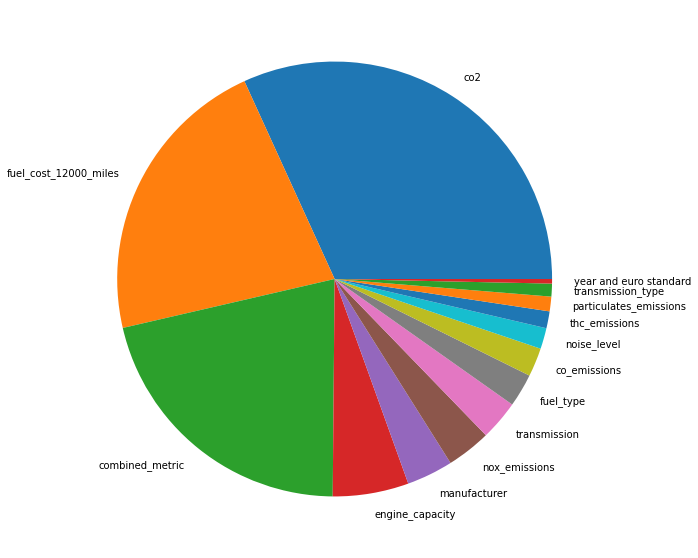

In [62]:
plt.figure(figsize=(10,10))
fi_new.plot.pie(ylabel='')

In [ ]:
fig, ax = plt.subplots()  # Create a figure and an axes.
# ax.set_xlabel('x label')  # Add an x-label to the axes.
# ax.set_ylabel('y label')  # Add a y-label to the axes.
ax.set_title("Feature importance of random classifier model")  # Add a title to the axes.
# ax.legend()  # Add a legend.

fi_new.sort_values(ascending=False).plot.pie()